#Introduction

This notebook is my first venture into basic modeling and analysis with pandas and various sklearn modules & packages.

Link to the dataset: https://archive.ics.uci.edu/ml/datasets/Myocardial+infarction+complications 

This dataset contains 1700 rows and 124 columns, of which 12 are complications of myocardial infarction (MI). This dataset contains information of patients who survived acute MI long enough to be admitted to the ICU and assessed by the emergency cardiology team. Each row has one patient's basic information, history, lab values and findings, medications given, and MI complications/outcome. Of note, most of this information was collected during the first day of hospital admittance *without* any time related data (eg. what medication was administered as opposed to *what and when*)

The goal is to predict MI complications with information of admitted patients by the end of the *first day* only with the first preliminary information available to gain insight on a patient's prognosis as soon as possible.

#Packages

In [ ]:
!pip install category_encoders==2.*

In [2]:
import pandas as pd
import numpy as np

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

#wrangling, encoding, preprocessing
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV

#pipeline & modelling
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

#metrics
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [112]:
df = pd.read_csv('MI_dataset.csv')

#Importing & Wrangling Data

The time of admission to hospital: all input columns (2-112) except


*   93: R_AB_1_n
*   94: R_AB_2_n
*   95: R_AB_3_n
*   100: NA_R_1_n
*   101: NA_R_2_n
*   102: NA_R_3_n
*   103: NOT_NA_1_n
*   104: NOT_NA_1_n
*   105: NOT_NA_1_n

Can be used for prediction; 

In [113]:
def wrangle(df):
  #copy df
  df_wrangled = df.copy(deep=True)

  #uppercase all column names
  df_wrangled.columns = df.columns.str.upper()
  
  #drop columns not used for prediction
  cols = df_wrangled.columns
  drop_cols_index = [93, 94, 100, 101, 103, 104]
  cols_to_drop = [cols[i]for i in drop_cols_index]
  df_wrangled.drop(columns=cols_to_drop, inplace=True)
  print(f'Dropped Columns: {cols_to_drop}')

  #drop HCC/unique columns
  df_wrangled.drop(columns=['ID'], inplace=True)

  #drop majority null features (>90%)
  null_counts = df_wrangled.isnull().sum()
  cols_nulls = list(null_counts[null_counts > (len(df) * 0.90)].index)
  df_wrangled.drop(columns=cols_nulls, inplace=True)
  print(f'>90% null columns: {cols_nulls}')

  #(1) any complication, (2) any fibrinolytic therapy, feature(s)
  df_wrangled['MED_FIBR'] = df_wrangled.loc[:, 'FIBR_TER_01':'FIBR_TER_08'].sum(axis=1).apply(lambda x: 1 if x >= 1 else 0)
  df_wrangled['ANY_COMPLICATION'] = df_wrangled.loc[:,'FIBR_PREDS':'LET_IS'].sum(axis=1).apply(lambda x: 1 if x >= 1 else 0)
  df_wrangled['MED_OPIOID'] = df_wrangled.loc[:,['NA_KB', 'NA_R_1_N']].sum(axis=1).apply(lambda x: 1 if x >= 1 else 0)
  df_wrangled['MED_NSAID'] = df_wrangled.loc[:, ['NOT_NA_KB', 'NOT_NA_1_N']].sum(axis=1).apply(lambda x: 1 if x >= 1 else 0)
  df_wrangled['MED_PAIN'] = df_wrangled.loc[:,['NA_KB', 'NA_R_1_N', 'NOT_NA_KB', 'NOT_NA_1_N', 'LID_KB']].sum(axis=1).apply(lambda x: 1 if x >= 1 else 0)
 

  # #change categorical columns to object, numericals as float
  # df = df.astype(object)
  # cols_numeric = list((df_mi.nunique() > 10)[(df_mi.nunique() > 10) == True].index)
  # df[cols_numeric] = df[cols_numeric].astype(float)
  # print(f'Numeric columns: {cols_numeric}')
  
  return df_wrangled



In [114]:
df_mi = wrangle(df)

Dropped Columns: ['R_AB_2_N', 'R_AB_3_N', 'NA_R_2_N', 'NA_R_3_N', 'NOT_NA_2_N', 'NOT_NA_3_N']
>90% null columns: ['IBS_NASL', 'KFK_BLOOD']


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3d6cd7a090>,
      dtype=object)

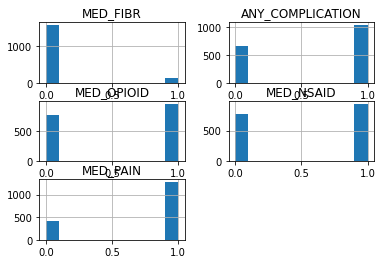

In [118]:
df_mi.loc[:, 'MED_FIBR':'MED_PAIN'].hist()

In [ ]:
#check for majority null (>90%) features
#df_mi.isnull().sum()[df_mi.isnull().sum() > (len(df_mi) * 0.90)]

#IBS_NASL: CHD heredity
#KFK_BLOOD: Serum CPK content

#Target: any complication
Binary target column: ANY_COMPLICATION (by end of follow-up/subacute period)
Includes:
* x
* y
* z



In [119]:
#all target columns
targets = ['FIBR_PREDS', 'PREDS_TAH', 'JELUD_TAH', 'FIBR_JELUD', 'A_V_BLOK', 
           'OTEK_LANC', 'RAZRIV', 'DRESSLER', 'ZSN', 'REC_IM', 'P_IM_STEN', 'LET_IS', 'ANY_COMPLICATION']

In [120]:
#Split into train and testing sets
y = df_mi['ANY_COMPLICATION']
X = df_mi.drop(columns=targets)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y, random_state=42)

print(f'Size of training set: {X_train.shape[0]}')
print(f'Size of testing set: {X_test.shape[0]}')

Size of training set: 1360
Size of testing set: 340


In [149]:
X_train

,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,GB,SIM_GIPERT,DLIT_AG,ZSN_A,NR_11,NR_01,NR_02,NR_03,NR_04,NR_07,NR_08,NP_01,NP_04,NP_05,NP_07,NP_08,NP_09,NP_10,ENDOCR_01,ENDOCR_02,ENDOCR_03,ZAB_LEG_01,ZAB_LEG_02,ZAB_LEG_03,ZAB_LEG_04,ZAB_LEG_06,S_AD_KBRIG,D_AD_KBRIG,S_AD_ORIT,D_AD_ORIT,O_L_POST,K_SH_POST,MP_TP_POST,SVT_POST,...,N_P_ECG_P_07,N_P_ECG_P_08,N_P_ECG_P_09,N_P_ECG_P_10,N_P_ECG_P_11,N_P_ECG_P_12,FIBR_TER_01,FIBR_TER_02,FIBR_TER_03,FIBR_TER_05,FIBR_TER_06,FIBR_TER_07,FIBR_TER_08,GIPO_K,K_BLOOD,GIPER_NA,NA_BLOOD,ALT_BLOOD,AST_BLOOD,L_BLOOD,ROE,TIME_B_S,R_AB_1_N,NA_KB,NOT_NA_KB,LID_KB,NITR_S,NA_R_1_N,NOT_NA_1_N,LID_S_N,B_BLOK_S_N,ANT_CA_S_N,GEPAR_S_N,ASP_S_N,TIKL_S_N,TRENT_S_N,MED_FIBR,MED_OPIOID,MED_NSAID,MED_PAIN
567,61.0,1,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,120.0,80.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.8,0.0,130.0,0.23,0.37,8.0,8.0,1.0,1.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0,1
1618,73.0,0,1.0,6.0,2.0,2.0,2.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,200.0,90.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.30,0.22,11.5,7.0,8.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,1
1031,59.0,1,0.0,6.0,2.0,2.0,2.0,0.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110.0,70.0,110.0,60.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.3,0.0,136.0,0.15,0.07,8.4,15.0,7.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0,1,0,1
1147,62.0,0,1.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120.0,80.0,140.0,80.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,136.0,0.61,0.22,8.0,2.0,3.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,1,1,1
828,53.0,1,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,146.0,0.90,0.82,12.1,19.0,7.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,70.0,0,1.0,5.0,2.0,1.0,2.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,170.0,100.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.2,0.0,140.0,0.38,0.22,3.8,7.0,9.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0,0,0,0
1362,86.0,1,1.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,110.0,60.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,7.2,40.0,1.0,0.0,1.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1,0,1
171,32.0,1,1.0,2.0,2.0,2.0,2.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,120.0,80.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,3.8,0.0,134.0,0.30,0.30,15.4,3.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1,1,1,1
982,37.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,180.0,80.0,180.0,120.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.8,0.0,133.0,0.61,0.30,5.5,8.0,9.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0,0,

##Baseline Accuracy

The baseline accuracy for a classification problem is simply the proportion of the majority class:

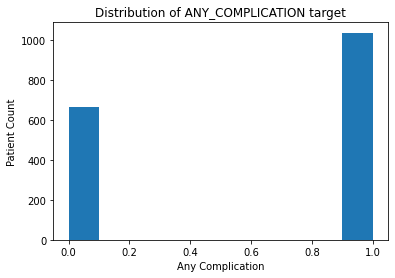

In [122]:
df_mi['ANY_COMPLICATION'].hist()
plt.ylabel('Patient Count')
plt.xlabel('Any Complication')
plt.title('Distribution of ANY_COMPLICATION target')
plt.grid()

In [123]:
baseline_acc = df_mi['ANY_COMPLICATION'].value_counts(normalize=True).max()
print(f'Baseline_accuracy: {baseline_acc}')

Baseline_accuracy: 0.61


## Models

###Logistic Regression

In [124]:
#build model
model_lr = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression()
)

In [125]:
#cross validate with StratifiedKFold
s5fold = StratifiedKFold(n_splits=5, shuffle=True)
cv_scores = cross_val_score(model_lr, X_train, y_train, cv=s5fold, scoring='accuracy')

print(f'CV Scores for stratified 5-fold CV: {cv_scores}')
print(f'Mean accuracy: {cv_scores.mean()}, STD: {cv_scores.std()}')
print(f'Improvement over baseline: {cv_scores.mean() - baseline_acc}')

CV Scores for stratified 5-fold CV: [0.73897059 0.67647059 0.68382353 0.68382353 0.69852941]
Mean accuracy: 0.6963235294117647, STD: 0.022495674324674055
Improvement over baseline: 0.08632352941176469


In [126]:
#fit & test linear regression model
model_lr.fit(X_train, y_train)
train_accuracy = model_lr.score(X_train, y_train)
test_accuracy = model_lr.score(X_test, y_test)

print(f'Training accuracy: {train_accuracy}')
print(f'Testing accuracy: {test_accuracy}')
print(f'Improvement over baseline: {test_accuracy - baseline_acc}')


Training accuracy: 0.7441176470588236
Testing accuracy: 0.7176470588235294
Improvement over baseline: 0.10764705882352943


### Random Forest

In [128]:
#build barebones model
model_rfc = make_pipeline(
    SimpleImputer(),
    RandomForestClassifier(n_jobs=-1)
)

# NAMED STEPS: 
# {'randomforestclassifier': RandomForestClassifier(),
#  'simpleimputer': SimpleImputer()}

In [ ]:
#rscv hyperparameter tuning

#total parameter permutations: 5600
param_dist={
    'simpleimputer__strategy': ['mean', 'median'],
    'randomforestclassifier__n_estimators': range(100, 401, 50),
    'randomforestclassifier__criterion':['gini', 'entropy'],
    'randomforestclassifier__max_depth': range(5, 51, 5),
    'randomforestclassifier__min_samples_split': range(2,11,2),
    'randomforestclassifier__min_samples_leaf': range(1,5,1)
}

rscv_rfc = RandomizedSearchCV(model_rfc, param_dist, n_iter=750, cv=5, 
                           scoring='accuracy', verbose=1, n_jobs=-1)

rscv_rfc.fit(X_train, y_train)

In [130]:
print(f'Best RSCV accuracy score: {rscv_rfc.best_score_}')
print(f'Best RSCV params: {rscv_rfc.best_params_}')

Best RSCV accuracy score: 0.7286764705882354
Best RSCV params: {'simpleimputer__strategy': 'mean', 'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__max_depth': 50, 'randomforestclassifier__criterion': 'gini'}


In [ ]:
#gscv hyperparameter tuning

param_grid={
    'simpleimputer__strategy': ['mean'],
    'randomforestclassifier__n_estimators': [150, 200, 250, 300],
    'randomforestclassifier__criterion':['gini'],
    'randomforestclassifier__max_depth': range(20, 71, 5),
    'randomforestclassifier__min_samples_split': range(2,6,2),
    'randomforestclassifier__min_samples_leaf': (1,2,3)
}

gscv_rfc = GridSearchCV(model_rfc, param_grid, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
gscv_rfc.fit(X_train, y_train)

In [132]:
print(f'Best GSCV accuracy score: {gscv_rfc.best_score_}')
print(f'Best GSCV params: {gscv_rfc.best_params_}')

Best GSCV accuracy score: 0.7257352941176471
Best GSCV params: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 20, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 300, 'simpleimputer__strategy': 'mean'}


In [194]:
#Final tuned model
tuned_model_rfc = make_pipeline(
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_estimators=300, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_jobs=-1),
)

tuned_model_rfc.fit(X_train, y_train)

print(f'Mean training accuracy: {tuned_model_rfc.score(X_train, y_train)}')
print(f'Mean testing accuracy: {tuned_model_rfc.score(X_test, y_test)}')
print(f'Average improvement over baseline: {tuned_model_rfc.score(X_test, y_test) - baseline_acc}')

Mean training accuracy: 1.0
Mean testing accuracy: 0.7323529411764705
Average improvement over baseline: 0.12235294117647055


###K-Nearest Neighbors

In [249]:
#build model
model_knn = make_pipeline(
    SimpleImputer(),
    KNeighborsClassifier(n_jobs=-1)
)

# {'kneighborsclassifier': KNeighborsClassifier(p=1, weights='distance'),
#  'simpleimputer': SimpleImputer()}

In [ ]:
#gscv hyperparameter tuning

#total parameter permutations:
param_grid_knn={
    'simpleimputer__strategy': ['mean', 'median'],
    'kneighborsclassifier__p': [1,2],
    'kneighborsclassifier__weights': ['distance', 'uniform'],
    'kneighborsclassifier__n_neighbors': range(3,25,1)
}

gscv_knn = GridSearchCV(model_knn, param_grid_knn, cv=s5fold, 
                        scoring='accuracy', verbose=1, n_jobs=-1)

gscv_knn.fit(X_train, y_train)

In [251]:
print(f'Best KNN GSCV accuracy score: {gscv_knn.best_score_}')
print(f'Best KNN GSCV params: {gscv_knn.best_params_}')

Best KNN GSCV accuracy score: 0.6330882352941176
Best KNN GSCV params: {'kneighborsclassifier__n_neighbors': 21, 'kneighborsclassifier__p': 2, 'kneighborsclassifier__weights': 'distance', 'simpleimputer__strategy': 'median'}


In [252]:
tuned_model_knn = make_pipeline(
    SimpleImputer(strategy='median'),
    KNeighborsClassifier(n_neighbors=21, weights='distance', p=2)
)

tuned_model_knn.fit(X_train, y_train)

train_accuracy_knn = tuned_model_knn.score(X_train, y_train)
test_accuracy_knn = tuned_model_knn.score(X_test, y_test)

print(f'KNN Training accuracy: {train_accuracy_knn}')
print(f'KNN Testing accuracy: {test_accuracy_knn}')
print(f'KNN Improvement over baseline: {test_accuracy_knn - baseline_acc}')

KNN Training accuracy: 1.0
KNN Testing accuracy: 0.6058823529411764
KNN Improvement over baseline: -0.004117647058823559


###Boosted Model

In [245]:
from sklearn.ensemble import AdaBoostClassifier

model_ada = make_pipeline(
    SimpleImputer(),
    AdaBoostClassifier()
)

#adacv hyperparameter tuning
param_grid={
    'simpleimputer__strategy': ['mean', 'median'],
    'adaboostclassifier__n_estimators': range(50, 101, 20),
    'adaboostclassifier__learning_rate': np.arange(0.1, 2.0, 0.2),
}

gscv_ada = GridSearchCV(model_ada, param_grid, scoring='accuracy', cv=s5fold, n_jobs=-1, verbose=1)
gscv_ada.fit(X_train, y_train)

print(f'Best GSCV accuracy score: {gscv_ada.best_score_}')
print(f'Best GSCV params: {gscv_ada.best_params_}')

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best GSCV accuracy score: 0.7058823529411764
Best GSCV params: {'adaboostclassifier__learning_rate': 0.30000000000000004, 'adaboostclassifier__n_estimators': 70, 'simpleimputer__strategy': 'mean'}


In [253]:
tuned_ada = make_pipeline(
    SimpleImputer(strategy='mean'),
    AdaBoostClassifier(n_estimators=70, learning_rate=0.3)
)

tuned_ada.fit(X_train, y_train)

train_accuracy_ada = tuned_ada.score(X_train, y_train)
test_accuracy_ada = tuned_ada.score(X_test, y_test)

print(f'Ada Training accuracy: {train_accuracy_ada}')
print(f'Ada Testing accuracy: {test_accuracy_ada}')
print(f'Ada Improvement over baseline: {test_accuracy_ada - baseline_acc}')


Ada Training accuracy: 0.7514705882352941
Ada Testing accuracy: 0.7352941176470589
Ada Improvement over baseline: 0.1252941176470589


## Metrics

### Logistic Regression

In [314]:
df_lr_coefs.abs().sort_values(by='coef').tail(n=15).index

Index(['FIBR_TER_02', 'NR_08', 'N_R_ECG_P_05', 'N_R_ECG_P_09', 'STENOK_AN',
       'ANT_IM', 'NR_04', 'AGE', 'N_P_ECG_P_04', 'INF_IM', 'NITR_S',
       'ZAB_LEG_02', 'ZSN_A', 'K_SH_POST', 'N_P_ECG_P_06'],
      dtype='object')

Text(0, 0.5, 'Feature')

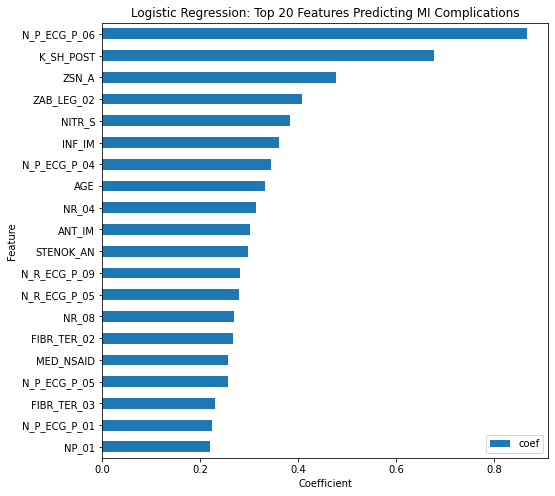

In [313]:

#dataframe for top 15 coefficients by absolute value
coefficients = model_lr.named_steps['logisticregression'].coef_.reshape(-1,1)
df_lr_coefs = pd.DataFrame(data=coefficients, index=X_train.columns, columns=['coef'])
df_lr_top20_coef = df_lr_coefs.abs().sort_values(by='coef').tail(n=20)
# df_lr_top10_coef.index = ['FC_ANGINA', 'ECG_VT', 'ECG_SA_BLOCK', 'AN_ANGINA',
#        'ECG_T12AV_BLOCK', 'ECG_AF_PAR', 'AN_HF', 'MI_ANT', 'AN_OCB', 'AGE',
#        'NITR_S_ICU', 'MI_INF', 'STREPTOKINASE_1M', 'ICU_CARDS_SHOCK', 'ECG_3AV_BLOCK']

#Plot top 15 features by coefficient absolute value
fig, ax = plt.subplots(1,1, figsize=(8,8))
df_lr_top10_coef.plot(kind='barh', ax=ax)
ax.set_title('Logistic Regression: Top 20 Features Predicting MI Complications')
ax.set_xlabel('Coefficient')
ax.set_ylabel('Feature')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.64      0.65      0.64       133
           1       0.77      0.76      0.77       207

    accuracy                           0.72       340
   macro avg       0.70      0.71      0.71       340
weighted avg       0.72      0.72      0.72       340



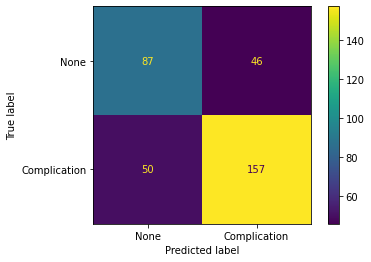

In [315]:
#confusion matrix

plot_confusion_matrix(model_lr, X_test, y_test, display_labels=['None', 'Complication'])
print(classification_report(y_test, model_lr.predict(X_test)))

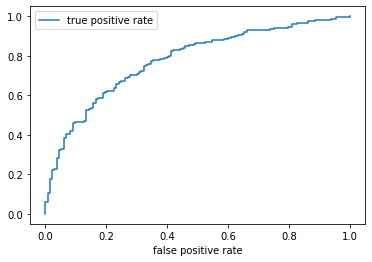

In [316]:
#roc, auc
fpr, tpr, thresholds = roc_curve(y_test, model_lr.predict_proba(X_test)[:,-1])

df_lr_rocauc = pd.DataFrame({'false positive rate': fpr, 'true positive rate': tpr, 'thresholds': thresholds})
df_lr_rocauc.plot(x='false positive rate', y='true positive rate')

In [317]:
df_lr_rocauc.sort_values(by='true positive rate', ascending=True).head(10)

,false positive rate,true positive rate,thresholds
0,0.000000,0.000000,1.999999
1,0.000000,0.004831,0.999999
2,0.000000,0.062802,0.999317
3,0.007519,0.062802,0.999281
4,0.007519,0.106280,0.997226
5,0.015038,0.106280,0.995462
6,0.015038,0.178744,0.968147
7,0.022556,0.178744,0.967209
9,0.030075,0.222222,0.950419
8,0.022556,0.222222,0.953983


###Random Forest

Text(0, 0.5, 'Feature')

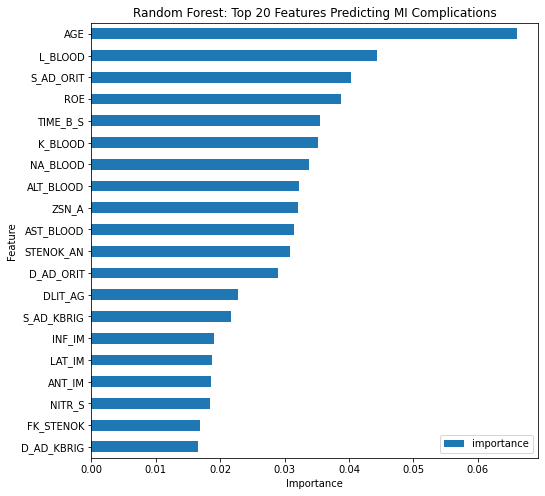

In [318]:
#Plot top 15 feature importances
importances_rfc = tuned_model_rfc.named_steps['randomforestclassifier'].feature_importances_
df_importances_rfc = pd.DataFrame(data=importances_rfc, index=X_train.columns, columns=['importance'])

fig, ax = plt.subplots(1,1, figsize=(8,8))
df_importances_rfc.sort_values(by='importance').tail(n=20).plot(kind='barh', ax=ax)
ax.set_title('Random Forest: Top 20 Features Predicting MI Complications')
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.72      0.51      0.60       133
           1       0.74      0.87      0.80       207

    accuracy                           0.73       340
   macro avg       0.73      0.69      0.70       340
weighted avg       0.73      0.73      0.72       340



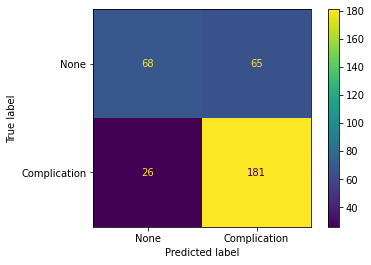

In [319]:
#confusion matrix

plot_confusion_matrix(tuned_model_rfc, X_test, y_test, display_labels=['None', 'Complication'])
print(classification_report(y_test, tuned_model_rfc.predict(X_test)))

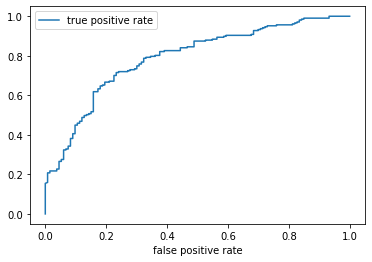

In [320]:
#roc, auc
fpr, tpr, thresholds = roc_curve(y_test, tuned_model_rfc.predict_proba(X_test)[:,-1])

df_rfc_rocauc = pd.DataFrame({'false positive rate': fpr, 'true positive rate': tpr, 'thresholds': thresholds})
df_rfc_rocauc.plot(x='false positive rate', y=['true positive rate'])

In [321]:
df_rfc_rocauc.sort_values(by='true positive rate', ascending=True).head(10)

,false positive rate,true positive rate,thresholds
0,0.000000,0.000000,1.953333
1,0.000000,0.004831,0.953333
2,0.000000,0.028986,0.900000
3,0.000000,0.038647,0.896667
4,0.000000,0.154589,0.830000
5,0.007519,0.159420,0.826667
6,0.007519,0.207729,0.803333
7,0.015038,0.207729,0.801198
8,0.015038,0.217391,0.796667
9,0.037594,0.217391,0.790000


####Permutations

In [323]:
#test permutations of all features
perm_features = list(df_importances_rfc.index)

test_accs = []
perm_accs = []

for f in perm_features:
  X_test_perm = X_test.copy()
  X_test_perm = pd.DataFrame(data=SimpleImputer().fit_transform(X_test_perm), columns=X_test_perm.columns)
  X_test_perm[f] = np.random.permutation(X_test_perm[f])

  test_accs.append(tuned_model_rfc.score(X_test, y_test))
  perm_accs.append(tuned_model_rfc.score(X_test_perm, y_test))


In [324]:
df_perm = pd.DataFrame(data={'Test Accuracy': test_accs, 'Permutation Accuracy': perm_accs})
df_perm['Change'] = df_perm['Test Accuracy'] - df_perm['Permutation Accuracy']
df_perm.index = perm_features

In [330]:
df_perm.sort_values(by='Change', ascending=False).head(n=10)

,Test Accuracy,Permutation Accuracy,Change
AGE,0.732353,0.697059,0.035294
ZSN_A,0.732353,0.700000,0.032353
ZAB_LEG_02,0.732353,0.708824,0.023529
NITR_S,0.732353,0.708824,0.023529
ROE,0.732353,0.711765,0.020588
NA_BLOOD,0.732353,0.714706,0.017647
INF_ANAM,0.732353,0.717647,0.014706
RITM_ECG_P_01,0.732353,0.717647,0.014706
ENDOCR_01,0.732353,0.717647,0.014706
TIME_B_S,0.732353,0.717647,0.014706


###Boosted Model

Text(0, 0.5, 'Feature')

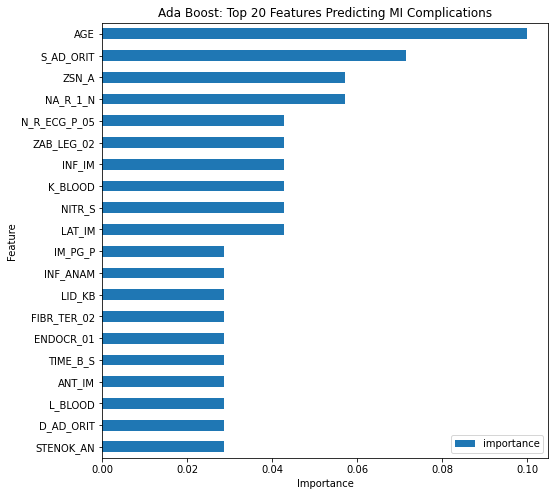

In [331]:
#Plot top 15 feature importances
importances_ada = tuned_ada.named_steps['adaboostclassifier'].feature_importances_
df_importances_ada = pd.DataFrame(data=importances_ada, index=X_train.columns, columns=['importance'])

fig, ax = plt.subplots(1,1, figsize=(8,8))
df_importances_ada.sort_values(by='importance').tail(n=20).plot(kind='barh', ax=ax)
ax.set_title('Ada Boost: Top 20 Features Predicting MI Complications')
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')

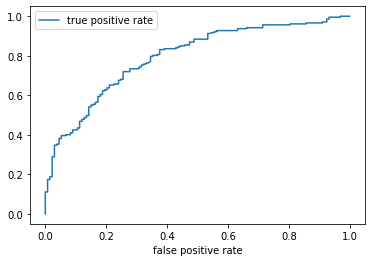

In [333]:
#roc, auc
fpr, tpr, thresholds = roc_curve(y_test, tuned_ada.predict_proba(X_test)[:,-1])

df_ada_rocauc = pd.DataFrame({'false positive rate': fpr, 'true positive rate': tpr, 'thresholds': thresholds})
df_ada_rocauc.plot(x='false positive rate', y=['true positive rate'])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.67      0.63      0.65       133
           1       0.77      0.80      0.79       207

    accuracy                           0.74       340
   macro avg       0.72      0.72      0.72       340
weighted avg       0.73      0.74      0.73       340



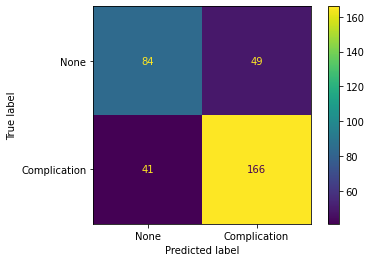

In [332]:
#confusion matrix

plot_confusion_matrix(tuned_ada, X_test, y_test, display_labels=['None', 'Complication'])
print(classification_report(y_test, tuned_ada.predict(X_test)))

In [334]:
df_ada_rocauc.sort_values(by='true positive rate', ascending=True).head(10)

,false positive rate,true positive rate,thresholds
0,0.000000,0.000000,1.898947
1,0.000000,0.004831,0.898947
2,0.000000,0.111111,0.553582
3,0.007519,0.111111,0.550397
4,0.007519,0.173913,0.533950
5,0.015038,0.173913,0.533890
6,0.015038,0.188406,0.532398
7,0.022556,0.188406,0.532141
8,0.022556,0.289855,0.523419
9,0.030075,0.289855,0.523359


###Comparison


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.wa

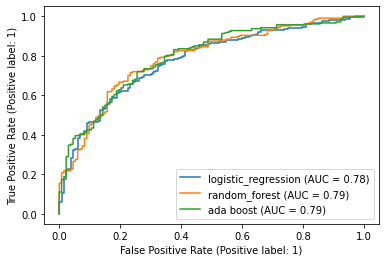

In [337]:
#Compared ROC curves for all models

lr_roc_curve = plot_roc_curve(model_lr, X_test, y_test, 
                              name='logistic_regression');

rfc_roc_curve = plot_roc_curve(tuned_model_rfc, X_test, y_test, 
                               ax=lr_roc_curve.ax_, name='random_forest');

ada_roc_curve = plot_roc_curve(tuned_ada, X_test, y_test, ax=lr_roc_curve.ax_, 
                               name='ada boost')

# Summary



*   Linear Regression Test Accuracy: 71.76%
*   Random Forest Test Accuracy: 73.24%
*   Ada Boost Test Accuracy: 73.53%

